# CIFAR-10 Classification

## 1. Prepare the Dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

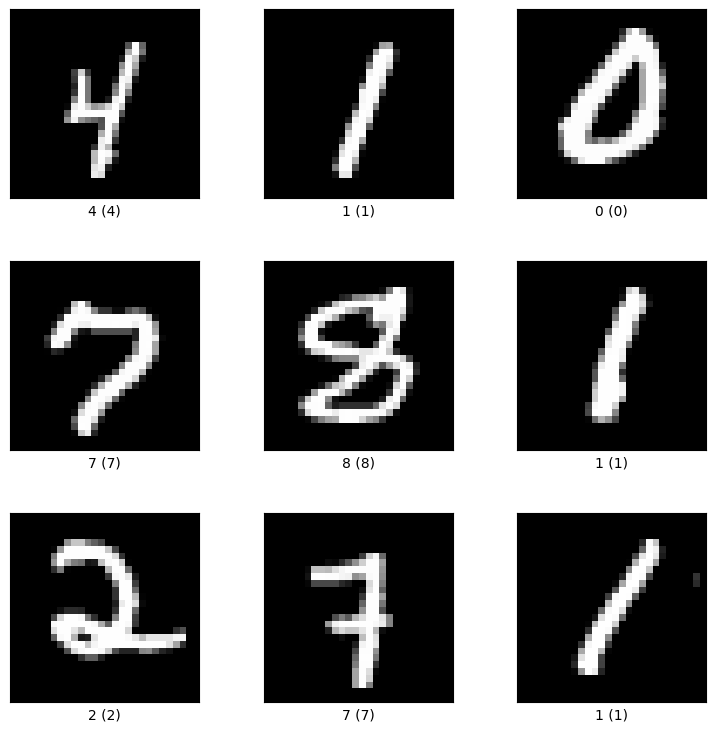

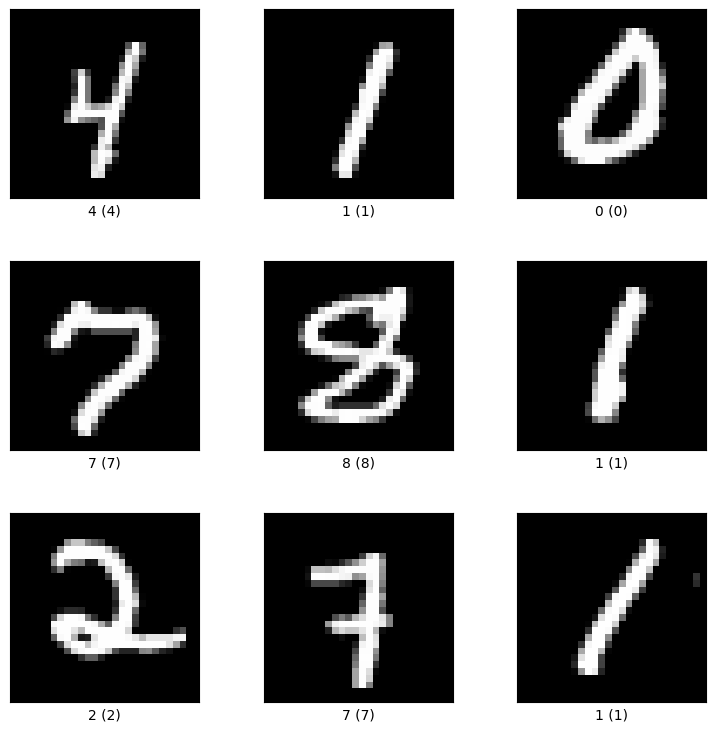

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

tfds.show_examples(ds_train, ds_info)


In [3]:
def prepare_data(mnist):
    # flatten images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target), num_parallel_calls=tf.data.AUTOTUNE)
    # normalize images from uint8 -> float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target), num_parallel_calls=tf.data.AUTOTUNE)
    # normalize inputs from 0-255 to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target), num_parallel_calls=tf.data.AUTOTUNE)
    # create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)), num_parallel_calls=tf.data.AUTOTUNE)
    # cache in memory
    mnist = mnist.cache()
    # mnist = mnist.shuffle(1000)
    mnist = mnist.shuffle(ds_info.splits['train'].num_examples)
    mnist = mnist.batch(32)
    # mnist = mnist.prefetch(20)
    mnist = mnist.prefetch(tf.data.AUTOTUNE)
    return mnist

ds_train = ds_train.apply(prepare_data)
ds_test = ds_test.apply(prepare_data)

## 2. The CNN Model

In [4]:
# Convolutional Neural Network
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

## 3. Training the network

In [5]:
def train_step(model, input, target, loss_function, accuracy_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = accuracy_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(mode, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [6]:
tf.keras.backend.clear_session()

def trainNet(model, num_epochs, learning_rate, optimizer):

    cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy_metrics = tf.keras.metrics.Accuracy()

    # optimizer = tf.keras.optimizers.Adam(learning_rate)

    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # check model performance on training data
    train_loss, train_acc = test(model, ds_train, cross_entropy_loss)
    train_losses.append(train_loss)
    # print(train_loss)
    # print(train_acc)
    train_accuracies.append(train_acc)

    for epoch in range(num_epochs):
        print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

        epoch_loss_agg = []
        epoch_acc_agg = []
        for input, target in ds_train:
            # print(str(optimizer))
            train_loss, train_acc = train_step(model, input, target, cross_entropy_loss, accuracy_metrics, optimizer)
            epoch_loss_agg.append(train_loss)
            epoch_acc_agg.append(train_acc)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))
        train_accuracies.append(tf.reduce_mean(epoch_acc_agg))
        # print("Train accuracy in epoch: ", train_accuracies[0])

        # testing to enable accuracy and test loss tracking
        test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    return train_losses, train_accuracies, test_losses, test_accuracies


## 4. Visualisation

In [7]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    """
    Visualizes accuracy and loss for training and test data using
    the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red.

    Parameters
    ----------
    train_losses: numpy.ndarray
    training losses
    train_accuracies: numpy.ndarray
    training accuracies
    test_losses: numpy.ndarray
    test losses
    test_accuracies: numpy.ndarray
    test accuracies
    """

    plt.figure ()
    line1, = plt.plot (train_losses, "b-")
    line2, = plt.plot (test_losses, "r-")
    line3, = plt.plot (train_accuracies, "b:")
    line4, = plt.plot (test_accuracies, "r:")
    plt.xlabel ("Training steps")
    plt.ylabel ("Loss / Accuracy")
    plt.legend ((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()


# Adjust parameters

Epoch: 0 starting with accuracy 0.07807507987220447
Epoch: 1 starting with accuracy 0.8888777955271565
Epoch: 2 starting with accuracy 0.924520766773163
Epoch: 3 starting with accuracy 0.9275159744408946
Epoch: 4 starting with accuracy 0.9095447284345048
Epoch: 5 starting with accuracy 0.9127396166134185
Epoch: 6 starting with accuracy 0.9137380191693291
Epoch: 7 starting with accuracy 0.9513777955271565
Epoch: 8 starting with accuracy 0.9412939297124601
Epoch: 9 starting with accuracy 0.952076677316294


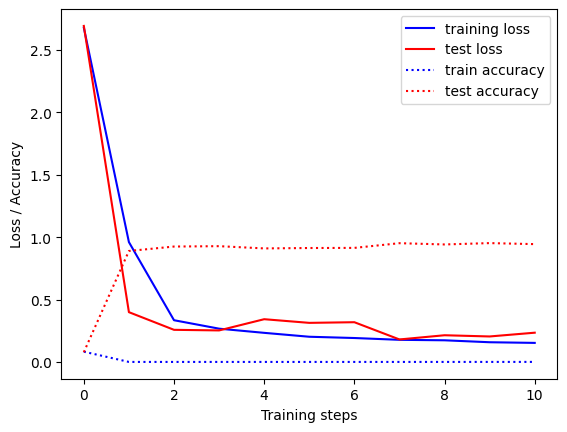

In [8]:

model = MyModel()

learning_rate1 = 0.2
optimizer1 = tf.keras.optimizers.SGD(learning_rate1)

# trainNet(model, num_epochs, learning_rate, optimizer="Categorigal Crossentropy"):
train_losses, train_accuracies, test_losses, test_accuracies = trainNet(model, 10, learning_rate1, optimizer1)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)